In [1]:
import galsim
import batsim.stamp as batstamp
import batsim.transforms as batforms
import batsim._gsinterface as _gsi

import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pyplot as plt
import fpfs
from time import time

from tqdm import tqdm, trange

In [12]:
cosmos_CAT = galsim.COSMOSCatalog()

ngals = len(cosmos_CAT)
gsparams = galsim.GSParams(maximum_fft_size=512*20, folding_threshold=1.e-3)
print("Number of galaxies in COSMOS catalog: ", ngals)

# Generate all galaxies
cosmos_gals = cosmos_CAT.makeGalaxy(index=np.arange(ngals), noise_pad_size=0, gal_type='parametric')

stamp_sz = np.empty((ngals))
for i, gal in tqdm(enumerate(cosmos_gals)):
    nq_scale = gal.nyquist_scale
    stamp_sz[i] = gal.getGoodImageSize(nq_scale)

Number of galaxies in COSMOS catalog:  81499


81499it [02:05, 647.09it/s] 


In [13]:
print(stamp_sz)

[  134.  2428.    80. ...   180.  1404. 22634.]


In [29]:
large_stamps = np.where(stamp_sz > 4000)[0]
print("Number of large stamps: ", len(large_stamps))

largest = np.argmax(stamp_sz)
print("Largest stamp: ", largest, stamp_sz[largest])

Number of large stamps:  28698
Largest stamp:  78987 1691364.0


Number of smaller stamps:  52801


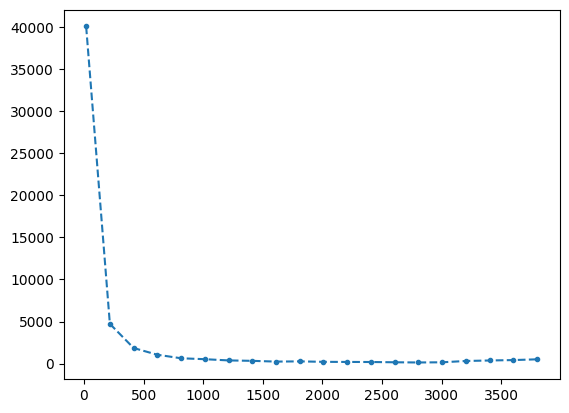

In [30]:
# Select only smaller stamps
cosmos_gals_sel = np.delete(cosmos_gals, large_stamps)
stamp_sel = np.delete(stamp_sz, large_stamps)
print("Number of smaller stamps: ", len(cosmos_gals_sel))

# plot distribution of remaining stamp sizes
size_freq, size_bins = np.histogram(stamp_sel, bins=20)
plt.plot(size_bins[:-1], size_freq, ls='--', marker='.')
plt.show()

In [31]:
# Estimate the runtime for the sample
rng = np.random.RandomState(1)
bin_runtime = np.empty((len(size_bins)))

diameter = 8.4  # meters
effective_diameter = 6.423  # meters, area weighted
seeing = 0.67  # arcseconds

psf = galsim.Moffat(beta=3.5, fwhm=0.8, flux=1.0)
#TotPSF = AtmosphericPSF

gamma1 = 0.02
gamma2 = 0.
kappa = 0.
Lens = batforms.LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa, center=None)

times = []
chosen_sz = []
for i in trange(len(size_bins)-1):
    bin_inds = np.where((stamp_sel >= size_bins[i]) & (stamp_sel < size_bins[i+1]))[0]
    chosen_ind = rng.choice(bin_inds, 1)[0]
    gal = cosmos_gals_sel[chosen_ind]
    sim_scale = gal.nyquist_scale
    sim_nn = gal.getGoodImageSize(sim_scale)
    chosen_sz.append(sim_nn)

    # Estimate runtime
    start = time()

    stamp = batstamp.Stamp(nn=128, scale=0.2, centering='fpfs')
    stamp.set_transform(Lens)
    batsim_im = stamp.sample_convolution(gal, psf)
    
    end = time()
    times.append(end-start)

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:03<00:08,  1.41it/s]

In [ ]:
print(times)
print(size_bins)
total_time = np.sum(times * size_freq)
scale_up = 1e6 / len(stamp_sel)
print("Total runtime: ", scale_up * total_time/(60**2 * 24), "days")

[0.038169145584106445, 0.24768543243408203, 0.9170558452606201, 0.52187180519104, 0.9755334854125977, 1.3111169338226318, 2.2530953884124756, 2.118056058883667, 3.2686262130737305, 3.2336971759796143, 3.6329667568206787, 5.739269733428955, 7.8740527629852295, 9.266615390777588, 10.117210865020752, 11.514971256256104, 17.21295475959778, 15.361173391342163, 13.607619762420654, 38.04848527908325]
[  18.   417.1  816.2 1215.3 1614.4 2013.5 2412.6 2811.7 3210.8 3609.9
 4009.  4408.1 4807.2 5206.3 5605.4 6004.5 6403.6 6802.7 7201.8 7600.9
 8000. ]
Total runtime:  21.20683488668121 days


Text(0.5, 0, 'Stamp size / pixels')

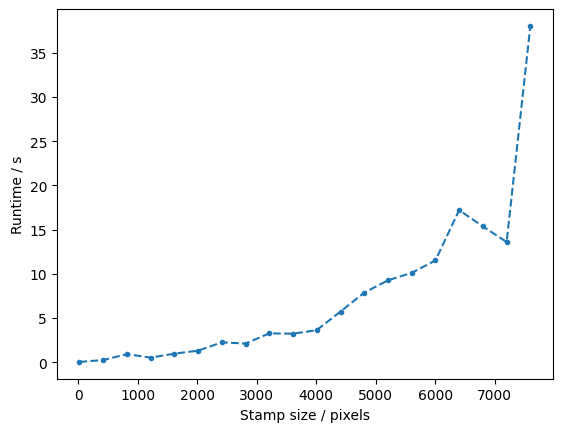

In [21]:
plt.plot(size_bins[:-1], times, ls='--', marker='.')
plt.ylabel('Runtime / s')
plt.xlabel('Stamp size / pixels')